# Building Type Data
- What does intensity look like for each building type? 
    - Hospitals the worst- most in district 3
    - College/university also bad and they ALSO have labs, data centers
- Sum total emissions, square footage by each building type
- Currently in mayor's proposal vs. what we want
- Stretch goal: cute visualization for people in legislation
- total ghg per building type and also as a fraction of city-wide emissions

In [66]:
import seaborn as sns

In [67]:
import numpy as np
import pandas as pd
import geopandas as gp
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
import util
from scipy import stats

Building WATERWORKS OFFICE & MARINA 2353 doesn't have a district POINT (-122.33895 47.63575)
	 Found district 7 for WATERWORKS OFFICE & MARINA
Building NAUTICAL LANDING 2381 doesn't have a district POINT (-122.34219 47.64306)
	 Found district 7 for NAUTICAL LANDING
Building UNION HARBOR CONDOMINIUM 2540 doesn't have a district POINT (-122.33003 47.6401)
	 Found district 4 for UNION HARBOR CONDOMINIUM
Building THE PIER AT LESCHI 2997 doesn't have a district POINT (-122.28563 47.59926)
	 Found district 3 for THE PIER AT LESCHI
Building THE LAKESHORE 3046 doesn't have a district POINT EMPTY


c:\Users\linne\miniconda3\envs\bps\lib\site-packages\shapely\predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


Building EDUCARE 3218 doesn't have a district POINT EMPTY


,OSEBuildingID,DataYear,BuildingName,BuildingType,TaxParcelIdentificationNumber,Address,City,State,ZipCode,Latitude,...,Electricity(kWh),SteamUse(kBtu),NaturalGas(therms),ComplianceStatus,ComplianceIssue,Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,geometry
0,1,2020,MAYFLOWER PARK HOTEL,NonResidential,0659000030,405 OLIVE WAY,SEATTLE,WA,98101.0,47.61220,...,801392,1457837,6326,Compliant,No Issue,2734351.0,632586.0,169.1,1.9,POINT (-122.33799 47.61220)
1,2,2020,PARAMOUNT HOTEL,NonResidential,0659000220,724 PINE ST,SEATTLE,WA,98101.0,47.61317,...,568667,0,16614,Compliant,No Issue,1940292.0,1661402.0,98.6,1.1,POINT (-122.33393 47.61317)
2,3,2020,WESTIN HOTEL (Parent Building),NonResidential,0659000475,1900 5TH AVE,SEATTLE,WA,98101.0,47.61367,...,7478716,10359896,8955,Compliant,No Issue,25517379.0,895500.0,1043.2,1.4,POINT (-122.33822 47.61367)
3,5,2020,HOTEL MAX,NonResidential,0659000640,620 STEWART ST,SEATTLE,WA,98101.0,47.61412,...,345231,917724,8871,Compliant,No Issue,1177927.0,887059.0,129.6,2.1,POINT (-122.33664 47.61412)
4,8,2020,WARWICK SEATTLE HOTEL,NonResidential,0659000970,401 LENORA ST,SEATTLE,WA,98121.0,47.61375,...,1102452,0,46034,Compliant,No Issue,3761566.0,4603411.0,264.5,2.3,POINT (-122.34047 47.61375)


In [85]:
df_districts = gp.read_file("Council_Districts.geojson")
df = pd.read_csv('2020_Building_Energy_Benchmarking.csv')
df = gp.GeoDataFrame(df, geometry=gp.points_from_xy(df.Longitude, df.Latitude))
util.clean_districts(df, df_districts)
df.head()

Building WATERWORKS OFFICE & MARINA 2353 doesn't have a district POINT (-122.33895 47.63575)
	 Found district 7 for WATERWORKS OFFICE & MARINA
Building NAUTICAL LANDING 2381 doesn't have a district POINT (-122.34219 47.64306)
	 Found district 7 for NAUTICAL LANDING
Building UNION HARBOR CONDOMINIUM 2540 doesn't have a district POINT (-122.33003 47.6401)
	 Found district 4 for UNION HARBOR CONDOMINIUM
Building THE PIER AT LESCHI 2997 doesn't have a district POINT (-122.28563 47.59926)
	 Found district 3 for THE PIER AT LESCHI
Building THE LAKESHORE 3046 doesn't have a district POINT EMPTY


c:\Users\linne\miniconda3\envs\bps\lib\site-packages\shapely\predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


Building EDUCARE 3218 doesn't have a district POINT EMPTY


,OSEBuildingID,DataYear,BuildingName,BuildingType,TaxParcelIdentificationNumber,Address,City,State,ZipCode,Latitude,...,Electricity(kWh),SteamUse(kBtu),NaturalGas(therms),ComplianceStatus,ComplianceIssue,Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,geometry
0,1,2020,MAYFLOWER PARK HOTEL,NonResidential,0659000030,405 OLIVE WAY,SEATTLE,WA,98101.0,47.61220,...,801392,1457837,6326,Compliant,No Issue,2734351.0,632586.0,169.1,1.9,POINT (-122.33799 47.61220)
1,2,2020,PARAMOUNT HOTEL,NonResidential,0659000220,724 PINE ST,SEATTLE,WA,98101.0,47.61317,...,568667,0,16614,Compliant,No Issue,1940292.0,1661402.0,98.6,1.1,POINT (-122.33393 47.61317)
2,3,2020,WESTIN HOTEL (Parent Building),NonResidential,0659000475,1900 5TH AVE,SEATTLE,WA,98101.0,47.61367,...,7478716,10359896,8955,Compliant,No Issue,25517379.0,895500.0,1043.2,1.4,POINT (-122.33822 47.61367)
3,5,2020,HOTEL MAX,NonResidential,0659000640,620 STEWART ST,SEATTLE,WA,98101.0,47.61412,...,345231,917724,8871,Compliant,No Issue,1177927.0,887059.0,129.6,2.1,POINT (-122.33664 47.61412)
4,8,2020,WARWICK SEATTLE HOTEL,NonResidential,0659000970,401 LENORA ST,SEATTLE,WA,98121.0,47.61375,...,1102452,0,46034,Compliant,No Issue,3761566.0,4603411.0,264.5,2.3,POINT (-122.34047 47.61375)


In [86]:
df = df[['OSEBuildingID', 
        'BuildingName', 
        'CouncilDistrictCode', 
        'YearBuilt', 
        'PropertyGFABuilding(s)', 
        'LargestPropertyUseType', 
        'TotalGHGEmissions', 
        'GHGEmissionsIntensity', 
        'EPAPropertyType',
        'geometry']]

## 1. Carbon intensity by building type

In [87]:
intensities = df.groupby(df['EPAPropertyType'])['GHGEmissionsIntensity'].mean().sort_values(ascending=False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(pd.DataFrame(intensities))

                                                    GHGEmissionsIntensity
EPAPropertyType                                                          
Laboratory                                                       7.726667
Hospital (General Medical & Surgical)                            7.450000
Data Center                                                      7.200000
Restaurant                                                       5.414286
Supermarket/Grocery Store                                        4.728947
College/University                                               4.721622
Other/Specialty Hospital                                         4.500000
Prison/Incarceration                                             4.300000
Other - Recreation                                               3.704348
Lifestyle Center                                                 3.500000
Urgent Care/Clinic/Other Outpatient                              3.300000
Museum                                

In [89]:
emissions = df.groupby(df['LargestPropertyUseType'])['GHGEmissionsIntensity'].mean().sort_values(ascending=False)
print(emissions)

LargestPropertyUseType
Hospital (General Medical & Surgical)    7.450000
Laboratory                               6.840000
Data Center                              5.933333
College/University                       4.546154
Supermarket/Grocery Store                4.521951
                                           ...   
Movie Theater                            0.300000
Energy/Power Station                     0.200000
Food Service                             0.200000
Convenience Store without Gas Station    0.100000
Bank Branch                              0.050000
Name: GHGEmissionsIntensity, Length: 63, dtype: float64


DescribeResult(nobs=1863, minmax=(masked_array(data=0.,
             mask=False,
       fill_value=1e+20), masked_array(data=7.1,
             mask=False,
       fill_value=1e+20)), mean=0.700107353730542, variance=0.6640708799834876, skewness=masked_array(data=2.21959931,
             mask=False,
       fill_value=1e+20), kurtosis=6.395554118744409)


count    1863.000000
mean        0.700107
std         0.814905
min         0.000000
25%         0.100000
50%         0.400000
75%         0.900000
max         7.100000
Name: GHGEmissionsIntensity, dtype: float64

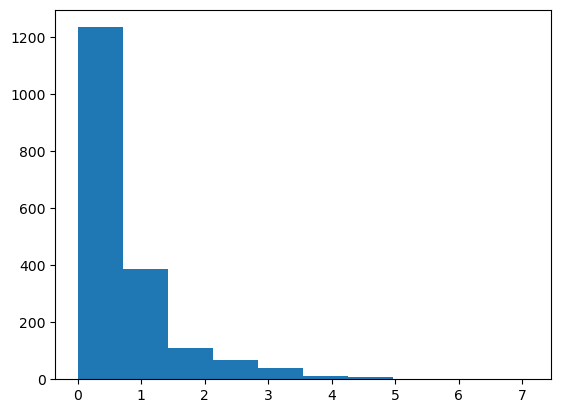

In [71]:
plt.hist(df[df['LargestPropertyUseType']=="Multifamily Housing"]['GHGEmissionsIntensity'])
print(stats.describe(df[df['LargestPropertyUseType']=="Multifamily Housing"]['GHGEmissionsIntensity'], nan_policy='omit'))
df[df['LargestPropertyUseType']=="Multifamily Housing"]['GHGEmissionsIntensity'].describe()

In [72]:
print(df['GHGEmissionsIntensity'].describe())
print(df['LargestPropertyUseType'].unique())

count    3593.000000
mean        1.081325
std         1.783603
min         0.000000
25%         0.200000
50%         0.600000
75%         1.300000
max        43.700000
Name: GHGEmissionsIntensity, dtype: float64
['Hotel' 'Police Station' 'Other - Entertainment/Public Assembly'
 'Multifamily Housing' 'Library' 'Fitness Center/Health Club/Gym'
 'Social/Meeting Hall' 'Courthouse' 'Prison/Incarceration' 'K-12 School'
 'College/University' 'Office' 'Self-Storage Facility' 'Parking'
 'Other - Mall' 'Senior Living Community' 'Medical Office' nan 'Other'
 'Performing Arts' 'Supermarket/Grocery Store'
 'Hospital (General Medical & Surgical)' 'Fire Station' 'Museum'
 'Repair Services (Vehicle, Shoe, Locksmith, etc)' 'Worship Facility'
 'Other - Lodging/Residential' 'Residence Hall/Dormitory' 'Retail Store'
 'Financial Office' 'Non-Refrigerated Warehouse' 'Other - Utility'
 'Transportation Terminal/Station' 'Laboratory' 'Convention Center'
 'Restaurant' 'Enclosed Mall' 'Data Center'
 'Outpatient 

Text(0, 0.5, 'Emissions Intensity')

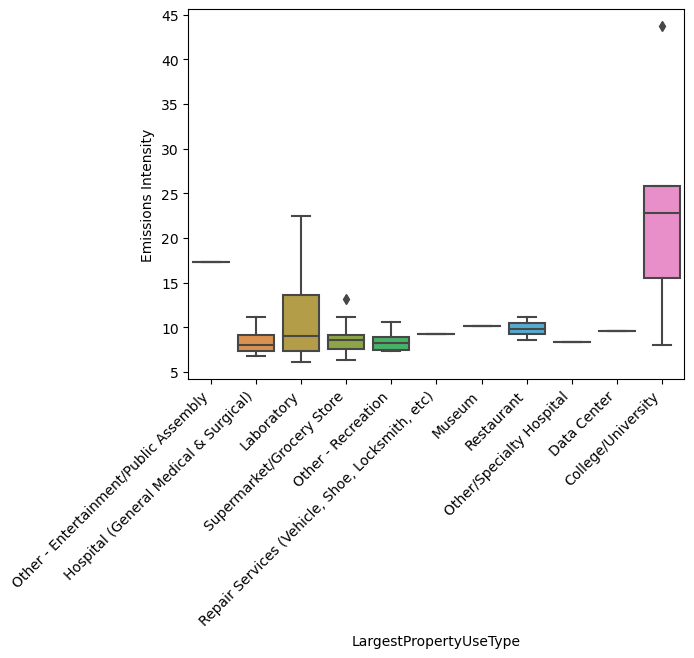

In [84]:
# Which categories in the high intensity have a lot of spread?
# Look at the groups with the highest average intensity. From there, make a boxplot of those 
# How many entertainment, museums, repair services, data centers are there really? 
# Look at how many buildings there are in each of these heavy hitters. Eg. mobilize hospital workers to get a LOT of hospitals 
# Do this by collective emissions as well? multifamily emits the most, but they have the most buildings. 
top_intense_values = intensities[intensities.values> intensities.quantile(0.75)]
top_intense_types = list(top_intense_values.keys())
df_intense = df[df['LargestPropertyUseType'].isin(top_intense_types)]

mdf= df_intense[df_intense['GHGEmissionsIntensity'] > 6.0].melt(id_vars=['LargestPropertyUseType'], value_vars='GHGEmissionsIntensity')
chart = sns.boxplot(x='LargestPropertyUseType', y='value', data=mdf)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_ylabel("Emissions Intensity")

In [94]:
# Top 10 building types by total GHGE emissions
df.groupby(df['EPAPropertyType']).mean().sort_values(by='GHGEmissionsIntensity',ascending=True)[:10]

# Top 10 building types by average intensity

C:\Users\linne\AppData\Local\Temp\ipykernel_13732\558557071.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(df['EPAPropertyType']).mean().sort_values(by='GHGEmissionsIntensity',ascending=True)[:10]


,OSEBuildingID,CouncilDistrictCode,YearBuilt,PropertyGFABuilding(s),TotalGHGEmissions,GHGEmissionsIntensity
EPAPropertyType,,,,,,
Bank Branch,23730.000000,7.000000,1960.50000,28164.000000,2.050,0.050
Convenience Store without Gas Station,26594.000000,7.000000,1900.00000,21420.000000,3.200,0.100
Other - Education,27704.000000,5.000000,1988.00000,32961.000000,1.700,0.100
Energy/Power Station,19697.000000,4.000000,1923.00000,21462.000000,5.200,0.200
Food Service,21508.000000,7.000000,1930.00000,22710.000000,4.400,0.200
Movie Theater,24513.000000,5.000000,1986.00000,33392.000000,9.800,0.300
Self-Storage Facility,19906.595745,4.425532,1968.12766,79800.255319,24.715,0.475
Multifamily Housing,27112.250000,5.000000,1970.25000,144461.000000,70.675,0.475
Pre-school/Daycare,49938.500000,0.500000,2009.50000,42213.500000,20.100,0.500


# Spread of carbon intensity in top offenders
- Look at hospitals, labs, data centers, college/universities, supermarkets, restaurants, multi-family
